In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os, sys, json, tempfile, pathlib, subprocess, re, time
from tqdm.auto import tqdm

# --- Biophysics and RNA Tools ---
# import RNA 
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist

# --- PyTorch for Neural Network ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Visualization and Metrics ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# --- Energy imports ---
from scipy.spatial.distance import cdist
from typing import Dict, List, Tuple, Optional

# --- Notebook Settings ---
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")
tqdm.pandas()

In [2]:
# --- Configuration ---
MODEL_CONFIG = {
    'ProteinX': {
        'predictions_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Protenix_Baseline_Train/submission.csv',
        'confidences_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Protenix_Baseline_Train/confidence.csv',
        'ranking_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Protenix_Baseline_Train/ranking_scores.csv' # Special file for ProteinX
    },
    'DrFo2': {
        'predictions_path': '/home/max/Documents/Standford_3DRNA_PredictionData/DRfold2_Baseline_train/submission.csv',
        'confidences_path': '/home/max/Documents/Standford_3DRNA_PredictionData/DRfold2_Baseline_train/confidence.csv',
        'ranking_path': None # DrFo2 doesn't have this
    },
    'Ribonanza': {
        'predictions_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Ribonanza_Baseline_Train/ribonanzanet2_submission_with_confidence_train.csv',
        'confidences_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Ribonanza_Baseline_Train/ribonanzanet2_submission_with_confidence_train.csv',
        'ranking_path': None # Ribonanza doesn't have a separate ranking file
    }
}

# Paths to the ground truth and sequence information
SEQUENCES_PATH = '/home/max/Documents/Protenix-KaggleRNA3D/data/stanford-rna-3d-folding/train_sequences_filtered.csv'
LABELS_PATH = '/home/max/Documents/Protenix-KaggleRNA3D/data/stanford-rna-3d-folding/train_labels_filtered.csv'

# Constants
NUM_PREDICTIONS_PER_MODEL = 5
NUCLEOTIDES = ['A', 'C', 'G', 'U']

In [3]:
# --- Data Loading and Pre-processing ---

print("--- Loading and Verifying Input Data ---")

# --- Step 1: Load common sequence and label files ---
try:
    df_sequences = pd.read_csv(SEQUENCES_PATH)
    df_labels = pd.read_csv(LABELS_PATH)
    
    print(f"✅ Loaded sequence data: {df_sequences.shape}")
    print(f"✅ Loaded label data: {df_labels.shape}\n")

except FileNotFoundError as e:
    print(f"FATAL ERROR: Cannot load base files: {e}.")
    print("Please check SEQUENCES_PATH and LABELS_PATH in the configuration cell.")

# --- Step 2: Load data for each model based on its configuration ---
data_dfs = {}
for model_name, config in MODEL_CONFIG.items():
    print(f"--- Processing model: {model_name} ---")
    try:
        is_combined_file = (config['predictions_path'] == config['confidences_path'])

        if is_combined_file and model_name == 'Ribonanza':
            # --- Special Handling for Ribonanza's combined format ---
            print("Detected combined Ribonanza format. Pre-processing...")
            df_raw = pd.read_csv(config['predictions_path'])
            
            # Create the predictions dataframe
            pred_cols = ['ID', 'resname', 'resid'] + [col for col in df_raw.columns if col.startswith(('x_', 'y_', 'z_'))]
            data_dfs[f'{model_name}_preds'] = df_raw[pred_cols].copy()
            
            # Create and rename the confidences dataframe
            conf_cols = ['ID', 'resname', 'resid'] + [f'confidence_{i}' for i in range(1, NUM_PREDICTIONS_PER_MODEL + 1)]
            rename_dict = {f'confidence_{i}': f'plddt_{i}' for i in range(1, NUM_PREDICTIONS_PER_MODEL + 1)}
            data_dfs[f'{model_name}_conf'] = df_raw[conf_cols].copy().rename(columns=rename_dict)
            
            print("✅ Ribonanza data successfully processed.")

        else:
            # --- Standard Handling for separate files (ProteinX, DrFo2) ---
            data_dfs[f'{model_name}_preds'] = pd.read_csv(config['predictions_path'])
            data_dfs[f'{model_name}_conf'] = pd.read_csv(config['confidences_path'])
            print("✅ Loaded separate prediction and confidence files.")

        # Load optional ranking file
        if config.get('ranking_path'):
            data_dfs[f'{model_name}_rank'] = pd.read_csv(config['ranking_path'])
            print("✅ Loaded optional ranking file.")

        # Display heads for verification
        print(f"  - Predictions head for {model_name}:")
        display(data_dfs[f'{model_name}_preds'].head(2))
        print(f"  - Confidences head for {model_name}:")
        display(data_dfs[f'{model_name}_conf'].head(2))

    except FileNotFoundError as e:
        print(f"Error loading files for {model_name}: {e}. Please check paths in MODEL_CONFIG.")
    except Exception as e:
        print(f"An unexpected error occurred while loading data for {model_name}: {e}")

print("\n--- ✅ Initial Data Loading and Pre-processing Complete ---")

--- Loading and Verifying Input Data ---
✅ Loaded sequence data: (760, 5)
✅ Loaded label data: (49687, 6)

--- Processing model: ProteinX ---
✅ Loaded separate prediction and confidence files.
✅ Loaded optional ranking file.
  - Predictions head for ProteinX:


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,1SCL_A_1,G,1,16.970413,-4.670355,-9.018064,10.486027,-13.865038,12.937576,2.908497,-6.447174,-18.863068,5.535280,16.883900,10.312805,-10.258783,-17.872894,0.623533
1,1SCL_A_2,G,2,15.244921,-7.541238,-4.707215,8.489288,-15.206691,8.009735,3.233741,-9.686610,-14.432230,9.314147,13.212024,8.888163,-5.246715,-17.285484,2.851788


  - Confidences head for ProteinX:


,ID,resname,resid,plddt_1,plddt_2,plddt_3,plddt_4,plddt_5
0,1SCL_A_1,G,1,88.5,88.5,88.5,88.5,88.5
1,1SCL_A_2,G,2,92.0,92.0,92.0,92.0,92.0


--- Processing model: DrFo2 ---
✅ Loaded separate prediction and confidence files.
  - Predictions head for DrFo2:


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,1SCL_A_1,G,1,-12.274610,19.907804,-3.127253,-9.209579,15.719687,-6.634937,-7.976545,16.119173,-11.591087,-0.032608,-18.876467,6.583105,-9.322432,-15.552121,11.254700
1,1SCL_A_2,G,2,-9.351652,19.744017,2.109739,-8.197619,16.321600,-0.804764,-5.482233,17.419617,-6.110267,-4.998965,-17.499321,3.518940,-9.056844,-10.724106,14.626364


  - Confidences head for DrFo2:


,ID,plddt_1,plddt_2,plddt_3,plddt_4,plddt_5
0,1SCL_A_1,0.415464,0.398302,0.409476,0.436324,0.432180
1,1SCL_A_2,0.461152,0.446779,0.462464,0.490731,0.485669


--- Processing model: Ribonanza ---
Detected combined Ribonanza format. Pre-processing...
✅ Ribonanza data successfully processed.
  - Predictions head for Ribonanza:


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,1SCL_A_1,G,1,15.348422,10.997616,-11.534798,3.308533,10.459855,19.488457,5.946423,15.54261,-14.663122,5.960367,12.393194,-16.763954,-20.98747,-7.266438,2.338508
1,1SCL_A_2,G,2,20.433796,10.614480,-7.886449,1.387454,5.994024,23.648623,3.058160,20.12456,-12.344646,10.572418,15.876827,-14.417734,-20.40904,-10.174376,8.315649


  - Confidences head for Ribonanza:


,ID,resname,resid,plddt_1,plddt_2,plddt_3,plddt_4,plddt_5
0,1SCL_A_1,G,1,0.799762,0.659163,0.429994,0.381455,0.728176
1,1SCL_A_2,G,2,0.799762,0.659163,0.429994,0.381455,0.728176



--- ✅ Initial Data Loading and Pre-processing Complete ---


In [4]:
def get_coords(df, pred_idx):
    """Extracts x, y, z coordinates for a specific prediction index."""
    return df[[f'x_{pred_idx}', f'y_{pred_idx}', f'z_{pred_idx}']].values

def calculate_radius_of_gyration(coords):
    center_of_mass = np.mean(coords, axis=0)
    return np.sqrt(np.mean(np.sum((coords - center_of_mass)**2, axis=1)))

def calculate_rmsd(coords1, coords2):
    if coords1.shape != coords2.shape: return np.nan
    coords1_centered = coords1 - coords1.mean(axis=0)
    coords2_centered = coords2 - coords2.mean(axis=0)
    rotation, rmsd = R.align_vectors(coords1_centered, coords2_centered)
    return rmsd

USALIGN_PATH = "/home/max/Documents/Protenix-KaggleRNA3D/af3-dev/USalign/USalign"
TEMP_DIR = "./temp_pdb/"
os.makedirs(TEMP_DIR, exist_ok=True)

# --- Functions for TM-Score ---

def parse_tmscore_output(output):
    """Your exact parsing function."""
    tm_score_match = re.findall(r'TM-score=\s+([\d.]+)', output)
    if len(tm_score_match) > 1:
        return float(tm_score_match[1])
    return np.nan

def write_target_line(atom_name, atom_serial, residue_name, chain_id, residue_num,
                      x_coord, y_coord, z_coord, occupancy=1.0, b_factor=0.0, atom_type='C'):
    """
    A corrected PDB line writer that strictly adheres to the PDB format specification.
    This prevents parsing errors and segmentation faults in external tools like USalign.
    """
    # Atom name should be space-padded on the left if < 4 characters.
    # Ex: ' CA ' or ' C1''
    atom_name_padded = f" {atom_name.ljust(3)}" if len(atom_name) < 4 else atom_name

    line = (
        f"ATOM  {atom_serial:5d} {atom_name_padded:<4s} {residue_name:<3s} {chain_id}"
        f"{residue_num:4d}    {x_coord:8.3f}{y_coord:8.3f}{z_coord:8.3f}"
        f"{occupancy:6.2f}{b_factor:6.2f}          {atom_type:>2s}  \n"
    )
    return line

def write2pdb(df: pd.DataFrame, xyz_id: int, target_path: str):
    """Your exact PDB writer function."""
    resolved_cnt = 0
    written_resids = set()
    with open(target_path, 'w') as f:
        for _, row in df.iterrows():
            resid = int(row['resid'])
            if resid in written_resids: continue
            
            x = row[f'x_{xyz_id}']
            y = row[f'y_{xyz_id}']
            z = row[f'z_{xyz_id}']
            if pd.notna(x) and x > -1e17:
                resolved_cnt += 1
                f.write(write_target_line(
                    atom_name="C1'", atom_serial=resid,
                    residue_name=row['resname'], chain_id='A',
                    residue_num=resid,
                    x_coord=x, y_coord=y, z_coord=z
                ))
                written_resids.add(resid)
    return resolved_cnt


def calculate_ground_truth_tm(pred_df, pred_idx, native_df):
    """Calculates the true TM-score using your exact logic."""
    best_tm_for_this_pred = 0.0
    pred_path = os.path.join(TEMP_DIR, 'predicted.pdb')
    native_path = os.path.join(TEMP_DIR, 'native.pdb')
    
    n_pred = write2pdb(pred_df, pred_idx, pred_path)
    if n_pred == 0: return 0.0

    native_indices = sorted(int(c.split('_')[1]) for c in native_df.columns if c.startswith('x_'))
    for nat_idx in native_indices:
        n_nat = write2pdb(native_df, nat_idx, native_path)
        if n_nat > 0:
            cmd = f'{USALIGN_PATH} {pred_path} {native_path} -atom " C1\'"'
            output = os.popen(cmd).read()
            tm = parse_tmscore_output(output)
            if tm is not None and tm > best_tm_for_this_pred:
                best_tm_for_this_pred = tm
    return best_tm_for_this_pred


In [5]:
class RNAEnergyScorer:
    def __init__(self):
        # Base pairing energies (kcal/mol) at 37°C
        self.base_pair_energies = {
            ('A', 'U'): -2.0, ('U', 'A'): -2.0,  # Watson-Crick AU
            ('G', 'C'): -3.0, ('C', 'G'): -3.0,  # Watson-Crick GC
            ('G', 'U'): -1.5, ('U', 'G'): -1.5,  # Wobble GU
        }
        
        # Stacking energies for consecutive base pairs (kcal/mol)
        # Format: ((base1, base2), (base3, base4)) where 1-2 and 3-4 are pairs
        self.stacking_energies = {
            (('A', 'U'), ('A', 'U')): -0.9,
            (('A', 'U'), ('G', 'C')): -2.1,
            (('G', 'C'), ('G', 'C')): -3.4,
            (('G', 'C'), ('A', 'U')): -2.3,
            (('G', 'U'), ('G', 'U')): -1.3,
            (('G', 'U'), ('G', 'C')): -2.5,
            (('G', 'U'), ('A', 'U')): -1.4,
        }
        
        # VdW radii for RNA atoms (Angstroms)
        self.vdw_radii = {
            'C': 1.7,   # Carbon
            'N': 1.55,  # Nitrogen
            'O': 1.52,  # Oxygen
            'P': 1.8,   # Phosphorus
        }
        
        # Ideal distances for hydrogen bonds (Angstroms)
        self.hbond_ideal_distance = 2.8
        self.hbond_max_distance = 3.5
        
    def calculate_base_pair_energy(self, sequence: str, coords: np.ndarray, cutoff_distance: float = 4.0) -> float:
        if len(sequence) != len(coords):
            return 0.0
            
        energy = 0.0
        distances = cdist(coords, coords)
        
        for i in range(len(sequence)):
            for j in range(i + 3, len(sequence)):  # Skip neighbors
                if distances[i, j] < cutoff_distance:
                    pair = (sequence[i], sequence[j])
                    if pair in self.base_pair_energies:
                        # Weight by distance (closer = stronger)
                        weight = 1.0 - (distances[i, j] / cutoff_distance)
                        energy += self.base_pair_energies[pair] * weight
                        
        return energy
    
    def calculate_stacking_energy(self, sequence: str, coords: np.ndarray) -> float:
        if len(sequence) < 2 or len(coords) < 2:
            return 0.0
            
        energy = 0.0
        
        # Calculate stacking between consecutive bases
        for i in range(len(sequence) - 1):
            # Distance between consecutive bases
            dist = np.linalg.norm(coords[i] - coords[i + 1])
            
            # Ideal stacking distance is around 3.4 Angstroms
            if 3.0 < dist < 4.0:
                # Simple stacking energy based on base types
                base1, base2 = sequence[i], sequence[i + 1]
                
                # Purine-purine stacking is stronger
                if base1 in ['A', 'G'] and base2 in ['A', 'G']:
                    energy += -1.5
                # Purine-pyrimidine
                elif (base1 in ['A', 'G'] and base2 in ['C', 'U']) or \
                     (base1 in ['C', 'U'] and base2 in ['A', 'G']):
                    energy += -1.0
                # Pyrimidine-pyrimidine is weakest
                else:
                    energy += -0.5
                    
        return energy
    
    def calculate_vdw_energy(self, coords: np.ndarray, epsilon: float = 0.1, clash_penalty: float = 10.0) -> float:
        if len(coords) < 2:
            return 0.0
            
        energy = 0.0
        distances = cdist(coords, coords)
        
        # Assume all atoms are carbon for simplicity (can be extended)
        sigma = 2 * self.vdw_radii['C']
        
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                r = distances[i, j]
                
                if r < 0.1:  # Avoid division by zero
                    energy += clash_penalty
                elif r < sigma * 2.5:  # Only calculate for nearby atoms
                    # Lennard-Jones potential
                    ratio = sigma / r
                    energy += 4 * epsilon * (ratio**12 - ratio**6)
                    
        return energy
    
    def calculate_electrostatic_energy(self, sequence: str, coords: np.ndarray, dielectric: float = 80.0) -> float:
        if len(coords) < 2:
            return 0.0
            
        # Phosphate groups have -1 charge
        charge = -1.0
        k_e = 332.0  # Coulomb's constant in kcal*Å/(mol*e²)
        
        energy = 0.0
        distances = cdist(coords, coords)
        
        for i in range(len(coords)):
            for j in range(i + 2, len(coords)):  # Skip neighbors
                r = distances[i, j]
                if r > 0.1:  # Avoid division by zero
                    # Coulomb's law with distance-dependent dielectric
                    effective_dielectric = dielectric * (1 + 0.1 * r)
                    energy += k_e * charge * charge / (effective_dielectric * r)
                    
        return energy
    
    def calculate_hydrogen_bond_energy(self, sequence: str, coords: np.ndarray) -> float:
        if len(sequence) != len(coords): return 0.0
            
        energy = 0.0
        distances = cdist(coords, coords)
        
        # Number of H-bonds per base pair type
        hbond_counts = {
            ('A', 'U'): 2, ('U', 'A'): 2,
            ('G', 'C'): 3, ('C', 'G'): 3,
            ('G', 'U'): 2, ('U', 'G'): 2,
        }
        
        for i in range(len(sequence)):
            for j in range(i + 3, len(sequence)):
                dist = distances[i, j]
                
                if dist < self.hbond_max_distance:
                    pair = (sequence[i], sequence[j])
                    if pair in hbond_counts:
                        # Energy per H-bond with distance dependence
                        if dist <= self.hbond_ideal_distance:
                            bond_energy = -1.0  # kcal/mol per H-bond
                        else:
                            # Linear decrease from ideal to max distance
                            factor = 1 - (dist - self.hbond_ideal_distance) / \
                                    (self.hbond_max_distance - self.hbond_ideal_distance)
                            bond_energy = -1.0 * factor
                            
                        energy += bond_energy * hbond_counts[pair]
                        
        return energy
    
    def calculate_solvation_energy(self, coords: np.ndarray, 
                                  probe_radius: float = 1.4) -> float:
        if len(coords) == 0:
            return 0.0
            
        # Simplified SASA calculation
        # Count neighbors within cutoff as buried
        cutoff = 5.0  # Angstroms
        distances = cdist(coords, coords)
        
        energy = 0.0
        for i in range(len(coords)):
            # Count neighbors
            neighbors = np.sum((distances[i] > 0) & (distances[i] < cutoff))
            
            # More neighbors = more buried = less solvation penalty
            # Assume -0.5 kcal/mol per exposed nucleotide
            exposure = max(0, 1 - neighbors / 6.0)  # 6 is roughly fully buried
            energy += -0.5 * exposure
            
        return energy
    
    def calculate_torsion_energy(self, coords: np.ndarray) -> float:
        if len(coords) < 4:
            return 0.0
            
        energy = 0.0
        
        # Calculate pseudo-torsion angles for consecutive 4 nucleotides
        for i in range(len(coords) - 3):
            # Get 4 consecutive points
            p1, p2, p3, p4 = coords[i:i+4]
            
            # Calculate vectors
            v1 = p2 - p1
            v2 = p3 - p2
            v3 = p4 - p3
            
            # Calculate normal vectors to planes
            n1 = np.cross(v1, v2)
            n2 = np.cross(v2, v3)
            
            # Avoid division by zero
            if np.linalg.norm(n1) > 0 and np.linalg.norm(n2) > 0:
                n1 = n1 / np.linalg.norm(n1)
                n2 = n2 / np.linalg.norm(n2)
                
                # Calculate dihedral angle
                cos_angle = np.clip(np.dot(n1, n2), -1, 1)
                angle = np.arccos(cos_angle)
                
                # Simple torsion potential (favors certain angles)
                # Minima at 0, π/3, 2π/3, π, 4π/3, 5π/3
                energy += 0.5 * (1 + np.cos(3 * angle))
                
        return energy
    
    def calculate_total_energy(self, sequence: str, coords: np.ndarray,
                             weights: Optional[Dict[str, float]] = None) -> Dict[str, float]:
        if weights is None:
            weights = {
                'base_pair': 1.0,
                'stacking': 0.5,
                'vdw': 0.3,
                'electrostatic': 0.2,
                'hbond': 0.8,
                'solvation': 0.4,
                'torsion': 0.3
            }
        
        energies = {
            'base_pair': self.calculate_base_pair_energy(sequence, coords),
            'stacking': self.calculate_stacking_energy(sequence, coords),
            'vdw': self.calculate_vdw_energy(coords),
            'electrostatic': self.calculate_electrostatic_energy(sequence, coords),
            'hbond': self.calculate_hydrogen_bond_energy(sequence, coords),
            'solvation': self.calculate_solvation_energy(coords),
            'torsion': self.calculate_torsion_energy(coords)
        }
        
        # Calculate weighted total
        total = sum(weights.get(key, 1.0) * value for key, value in energies.items())
        energies['total'] = total
        
        return energies


def extract_energy_features(sequence: str, coords: np.ndarray, scorer: Optional[RNAEnergyScorer] = None) -> Dict[str, float]:
    if scorer is None: scorer = RNAEnergyScorer()
    
    energies = scorer.calculate_total_energy(sequence, coords)
    features = energies.copy()
    
    # Energy per nucleotide
    n_nucleotides = len(sequence)
    if n_nucleotides > 0:
        features['energy_per_nucleotide'] = energies['total'] / n_nucleotides
        features['base_pair_per_nucleotide'] = energies['base_pair'] / n_nucleotides
    
    # Ratio features
    if energies['total'] != 0:
        features['base_pair_ratio'] = energies['base_pair'] / abs(energies['total'])
        features['hbond_ratio'] = energies['hbond'] / abs(energies['total'])
    
    # Stability score (lower energy = more stable)
    features['stability_score'] = -energies['total']
    
    return features

In [6]:
class MetaLearnerNN(nn.Module):
    def __init__(self, input_features):
        """
        Initializes the Neural Network architecture.
        
        Args:
            input_features (int): The number of input features for the model.
        """
        super(MetaLearnerNN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()  # TM-score is between 0 and 1, so Sigmoid is a simple choice
        )

    def forward(self, x):
        """The forward pass of the model."""
        return self.layers(x)


In [7]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN # <-- V3 Import for clustering

print("Starting V3 feature generation with Clustering, Nuanced Interactions, and Normalization...")

energy_scorer = RNAEnergyScorer()
meta_data_rows = []

# This helper function will compute the RMSD matrix needed for clustering
def calculate_pairwise_rmsd_matrix(coords_dict):
    candidate_keys = list(coords_dict.keys())
    coords_list = [coords_dict[key] for key in candidate_keys]
    n = len(candidate_keys)
    rmsd_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            # Check for valid coordinates before calculating RMSD
            if coords_list[i].shape[0] > 0 and coords_list[j].shape[0] > 0 and coords_list[i].shape == coords_list[j].shape:
                rmsd = calculate_rmsd(coords_list[i], coords_list[j])
                rmsd_matrix[i, j] = rmsd
                rmsd_matrix[j, i] = rmsd
            else:
                # Assign a large distance if shapes mismatch or coords are empty
                rmsd_matrix[i, j] = 999
                rmsd_matrix[j, i] = 999
                
    return rmsd_matrix, candidate_keys

# Main loop through each sequence
for _, sequence_row in tqdm(df_sequences.iterrows(), total=len(df_sequences), desc="Processing Targets"):
    target_id = sequence_row['target_id']
    sequence = sequence_row['sequence']
    
    native_df_for_target = df_labels[df_labels['ID'].str.startswith(f"{target_id}_")].copy()
    if native_df_for_target.empty:
        continue

    # Pre-calculate all 15 candidate coordinates
    all_candidate_coords = {}
    for model_name in MODEL_CONFIG:
        df_pred = data_dfs[f'{model_name}_preds']
        target_preds = df_pred[df_pred['ID'].str.startswith(f"{target_id}_")]
        if target_preds.empty: continue
        for i in range(1, NUM_PREDICTIONS_PER_MODEL + 1):
            coords = get_coords(target_preds, i)
            all_candidate_coords[f'{model_name}_{i}'] = coords

    # =============================================================================
    # V3 - NEW FEATURE: Clustering Analysis (Calculated once per target)
    # =============================================================================
    cluster_info = {}
    if len(all_candidate_coords) > 1:
        # 1. Create the pairwise RMSD matrix for all candidates of this target
        rmsd_matrix, candidate_keys = calculate_pairwise_rmsd_matrix(all_candidate_coords)
        
        # 2. Run DBSCAN to find clusters of structurally similar predictions
        # 'eps' is the max distance (RMSD) between two samples for one to be considered as in the neighborhood of the other.
        # 'min_samples' is the number of samples in a neighborhood for a point to be considered as a core point.
        dbscan = DBSCAN(eps=7.5, min_samples=2, metric='precomputed', n_jobs=-1)
        cluster_labels = dbscan.fit_predict(rmsd_matrix)
        
        # 3. Store the results for easy lookup in the loop below
        num_clusters_found = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        labels_series = pd.Series(cluster_labels)
        cluster_sizes = labels_series.value_counts().to_dict()
        
        for k_idx, key in enumerate(candidate_keys):
            label = cluster_labels[k_idx]
            cluster_info[key] = {
                'cluster_label': label,
                'is_outlier': 1 if label == -1 else 0,
                'cluster_size': cluster_sizes.get(label, 0),
                'num_clusters_total': num_clusters_found
            }

    # Now, loop through each of the 15 candidates to generate its feature row
    for model_name, config in MODEL_CONFIG.items():
        df_pred = data_dfs[f'{model_name}_preds']
        df_conf = data_dfs[f'{model_name}_conf']
        
        pred_df_for_target = df_pred[df_pred['ID'].str.startswith(f"{target_id}_")].copy()
        target_confs = df_conf[df_conf['ID'].str.startswith(f"{target_id}_")].copy()
        if pred_df_for_target.empty: continue
        
        df_rank = data_dfs.get(f'{model_name}_rank')
        target_rank = df_rank[df_rank['target_id'] == target_id] if df_rank is not None else None

        for i in range(1, NUM_PREDICTIONS_PER_MODEL + 1):
            candidate_key = f'{model_name}_{i}'
            if f'plddt_{i}' not in target_confs.columns or candidate_key not in all_candidate_coords:
                continue
            
            features = {'target_id': target_id, 'model_source': model_name, 'prediction_index': i}
            
            # --- V1 Features ---
            features['sequence_length'] = len(sequence)
            for nuc in NUCLEOTIDES: features[f'percent_{nuc}'] = sequence.count(nuc) / len(sequence)

            plddt_scores = target_confs[f'plddt_{i}'].values
            features.update({'mean_plddt': np.mean(plddt_scores), 'std_plddt': np.std(plddt_scores),
                             'min_plddt': np.min(plddt_scores), 'percent_low_conf': np.mean(plddt_scores < 70),
                             'percent_high_conf': np.mean(plddt_scores > 90)})
            
            if target_rank is not None and not target_rank.empty:
                features.update({'ptm': target_rank.iloc[0].get(f'ptm_{i}', 0),
                                 'ranking_score': target_rank.iloc[0].get(f'ranking_score_{i}', 0)})
            else:
                features.update({'ptm': 0, 'ranking_score': 0})

            candidate_coords = all_candidate_coords[candidate_key]
            if candidate_coords is None or candidate_coords.shape[0] == 0: continue
            
            features['radius_of_gyration'] = calculate_radius_of_gyration(candidate_coords)
            rmsd_to_others = [calculate_rmsd(candidate_coords, other_coords) for key, other_coords in all_candidate_coords.items() if key != candidate_key]
            features['avg_rmsd_to_others'] = np.nanmean(rmsd_to_others)
            
            # --- V2 Interaction Features ---
            base_mean_plddt = features['mean_plddt']
            base_std_plddt = features['std_plddt']
            base_radius_of_gyration = features['radius_of_gyration']
            for source in MODEL_CONFIG.keys():
                features[f'plddt_x_{source}'] = 0.0
                features[f'std_plddt_x_{source}'] = 0.0
                features[f'rog_x_{source}'] = 0.0
            features[f'plddt_x_{model_name}'] = base_mean_plddt
            features[f'std_plddt_x_{model_name}'] = base_std_plddt
            features[f'rog_x_{model_name}'] = base_radius_of_gyration

            # =============================================================================
            # V3 - NEW FEATURE: Add Clustering and Nuanced Confidence Interactions
            # =============================================================================
            # Add features from the clustering analysis done above
            info = cluster_info.get(candidate_key, {}) # Safely get the info
            features['cluster_label'] = info.get('cluster_label', -1)
            features['is_outlier'] = info.get('is_outlier', 1)
            features['cluster_size'] = info.get('cluster_size', 0)
            features['num_clusters_total'] = info.get('num_clusters_total', 0)
            
            # Add more specific confidence interactions
            base_percent_low_conf = features['percent_low_conf']
            base_percent_high_conf = features['percent_high_conf']
            for source in MODEL_CONFIG.keys():
                features[f'low_conf_x_{source}'] = 0.0
                features[f'high_conf_x_{source}'] = 0.0
            features[f'low_conf_x_{model_name}'] = base_percent_low_conf
            features[f'high_conf_x_{model_name}'] = base_percent_high_conf
            # =============================================================================

            try:
                energy_features = extract_energy_features(sequence, candidate_coords, energy_scorer)
                features.update({k: v for k, v in energy_features.items()}) # More concise update
                attractive_energy = energy_features['base_pair'] + energy_features['stacking'] + energy_features['hbond']
                repulsive_energy = energy_features['vdw'] + energy_features['electrostatic']
                features['energy_attractive'] = attractive_energy
                features['energy_repulsive'] = repulsive_energy
                features['energy_balance'] = attractive_energy / (abs(repulsive_energy) + 1e-6)
                features['energy_density'] = energy_features['total'] / (len(sequence) + 1e-6)
                energy_components = [energy_features[k] for k in ['base_pair', 'stacking', 'vdw', 'electrostatic', 'hbond', 'solvation', 'torsion']]
                features['energy_variance'] = np.var(energy_components)
                features['energy_std'] = np.std(energy_components)
            except Exception as e:
                # This block now needs to nullify all possible energy features
                energy_feature_names = [
                    'energy_total', 'energy_base_pair', 'energy_stacking', 'energy_vdw',
                    'energy_electrostatic', 'energy_hbond', 'energy_solvation', 'energy_torsion',
                    'energy_per_nucleotide', 'stability_score', 'base_pair_ratio', 'hbond_ratio',
                    'energy_attractive', 'energy_repulsive', 'energy_balance', 'energy_density',
                    'energy_variance', 'energy_std'
                ]
                for feat_name in energy_feature_names: features[feat_name] = 0.0
            
            # =============================================================================
            # V3 - NEW FEATURE: Normalized Physical Features
            # =============================================================================
            seq_len = features['sequence_length']
            if seq_len > 0:
                features['rog_normalized'] = features['radius_of_gyration'] / np.sqrt(seq_len)
                solvation_energy = features.get('energy_solvation', 0)
                features['solvation_per_residue'] = solvation_energy / seq_len
            else:
                features['rog_normalized'] = 0.0
                features['solvation_per_residue'] = 0.0
            # =============================================================================
            
            # TARGET VARIABLE: The real TM-score
            tm_score = calculate_ground_truth_tm(pred_df_for_target, i, native_df_for_target)
            features['tm_score'] = tm_score
            
            meta_data_rows.append(features)

# --- Finalize and Check DataFrame ---
df_meta = pd.DataFrame(meta_data_rows)

# Create a fixed, explicit mapping for model names to numbers
model_mapping = {name: i for i, name in enumerate(MODEL_CONFIG.keys())}
print("\nUsing fixed model mapping:", model_mapping)

# Apply the mapping. The original 'model_source' column contains the string names.
df_meta['model_source'] = df_meta['model_source'].map(model_mapping)

print("\n--- Feature Generation Complete ---")
print(f"Total features created: {len(df_meta.columns) - 3}") # -3 for id, index, score
print("\nMissing Values Check:")
print(df_meta.isnull().sum()[df_meta.isnull().sum() > 0]) # Show only columns with NaNs
df_meta.fillna(df_meta.median(numeric_only=True), inplace=True)

print("\nDataFrame sample (first 5 rows with new features):")
display(df_meta[['target_id', 'model_source', 'is_outlier', 'cluster_size', 'rog_normalized', 'low_conf_x_ProteinX', 'low_conf_x_Ribonanza']].head())

df_meta.to_csv('meta_learner_training_data_v3.csv', index=False)
print("✅ Successfully saved the V3 meta-learner data.")

Starting V3 feature generation with Clustering, Nuanced Interactions, and Normalization...


Processing Targets:   0%|          | 0/760 [00:00<?, ?it/s]

Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too shor


Using fixed model mapping: {'ProteinX': 0, 'DrFo2': 1, 'Ribonanza': 2}

--- Feature Generation Complete ---
Total features created: 55

Missing Values Check:
Series([], dtype: int64)

DataFrame sample (first 5 rows with new features):


,target_id,model_source,is_outlier,cluster_size,rog_normalized,low_conf_x_ProteinX,low_conf_x_Ribonanza
0,1SCL_A,0,0,5,2.822115,0.0,0.0
1,1SCL_A,0,0,5,2.835325,0.0,0.0
2,1SCL_A,0,0,5,2.833282,0.0,0.0
3,1SCL_A,0,0,5,2.796889,0.0,0.0
4,1SCL_A,0,0,5,2.814125,0.0,0.0


✅ Successfully saved the V3 meta-learner data.


--- Starting V2 Training with LightGBM ---
Training data shape: (9120, 56)
Validation data shape: (2280, 56)

Training model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10283
[LightGBM] [Info] Number of data points in the train set: 9120, number of used features: 53
[LightGBM] [Info] Start training from score 0.442589
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's l2: 0.00532244

--- Model Evaluation ---
Validation MSE: 0.005322
Validation R²:  0.9146

✅ Model saved to meta_learner_lgbm.pkl

--- Feature Importance Analysis ---


<Figure size 1800x1200 with 0 Axes>

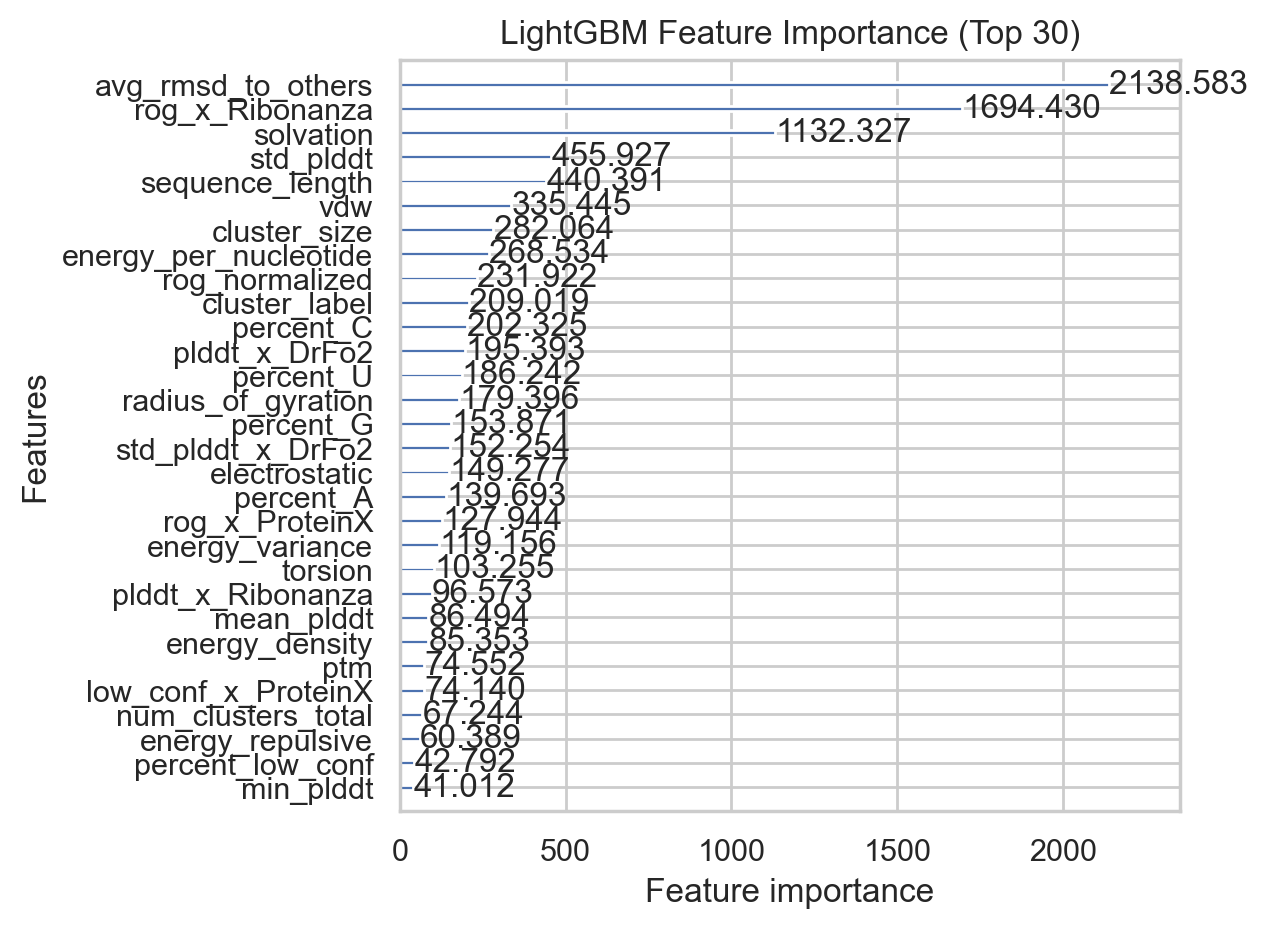

In [ ]:
import lightgbm as lgb
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting V2 Training with LightGBM ---")

if 'df_meta' not in locals() or df_meta.empty:
    print("FATAL: df_meta not found or is empty. Please run the feature generation cell first.")
else:
    # 1. Define Features (X) and Target (y)
    feature_cols = [col for col in df_meta.columns if col not in ['target_id', 'tm_score']]
    X = df_meta[feature_cols]
    y = df_meta['tm_score']

    # --- Convert column names to be compatible with LightGBM ---
    X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]

    # 2. Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # 3. Initialize and Train the LightGBM Model
    lgbm = lgb.LGBMRegressor(
        random_state=42,
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=31,
        n_jobs=-1,
        colsample_bytree=0.8,
        subsample=0.8,
        reg_alpha=0.1,          # L1 regularization
        reg_lambda=0.1          # L2 regularization
    )

    print("\nTraining model...")
    lgbm.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
    )

    # 4. Evaluate the Model
    print("\n--- Model Evaluation ---")
    val_preds = lgbm.predict(X_val)
    
    mse = mean_squared_error(y_val, val_preds)
    r2 = r2_score(y_val, val_preds)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation R²:  {r2:.4f}")

    # 5. Save the Trained Model
    MODEL_SAVE_PATH = 'meta_learner_lgbm.pkl'
    joblib.dump(lgbm, MODEL_SAVE_PATH)
    print(f"\n✅ Model saved to {MODEL_SAVE_PATH}")

    # 6. Analyze Feature Importance (Crucial for your Report!)
    print("\n--- Feature Importance Analysis ---")
    plt.figure(figsize=(18, 12))
    lgb.plot_importance(
        lgbm,
        max_num_features=30, # Show top 30 most important features
        importance_type='gain', # 'gain' is the total gain of splits which use the feature
        title='LightGBM Feature Importance (Top 30)'
    )
    plt.tight_layout()
    plt.show()